In [1]:
import torch
import numpy as np

import torch.nn.functional as F
import torch.nn
from torch.autograd import Variable

import torch.backends.cudnn as cudnn


use_cuda = torch.cuda.is_available()


In [2]:
class E2EBlock(torch.nn.Module):
    '''E2Eblock.'''

    def __init__(self, in_planes, planes,example,bias=False):
        super(E2EBlock, self).__init__()
        self.d = example.size(3)
        self.cnn1 = torch.nn.Conv2d(in_planes,planes,(1,self.d),bias=bias)
        self.cnn2 = torch.nn.Conv2d(in_planes,planes,(self.d,1),bias=bias)

        
    def forward(self, x):
        a = self.cnn1(x)
        b = self.cnn2(x)
        return torch.cat([a]*self.d,3)+torch.cat([b]*self.d,2)



BrainNetCNN Network for fitting Gold-MSI on LSD dataset

In [3]:
class BrainNetCNN(torch.nn.Module):
    def __init__(self, example, num_classes=10):
        super(BrainNetCNN, self).__init__()
        self.in_planes = example.size(1)
        self.d = example.size(3)
        
        self.e2econv1 = E2EBlock(1,32,example,bias=True)
        self.e2econv2 = E2EBlock(32,64,example,bias=True)
        self.E2N = torch.nn.Conv2d(64,1,(1,self.d))
        self.N2G = torch.nn.Conv2d(1,256,(self.d,1))
        self.dense1 = torch.nn.Linear(256,128)
        self.dense2 = torch.nn.Linear(128,30)
        self.dense3 = torch.nn.Linear(30,2)
        
    def forward(self, x):
        out = F.leaky_relu(self.e2econv1(x),negative_slope=0.33)
        out = F.leaky_relu(self.e2econv2(out),negative_slope=0.33) 
        out = F.leaky_relu(self.E2N(out),negative_slope=0.33)
        out = F.dropout(F.leaky_relu(self.N2G(out),negative_slope=0.33),p=0.5)
        out = out.view(out.size(0), -1)
        out = F.dropout(F.leaky_relu(self.dense1(out),negative_slope=0.33),p=0.5)
        out = F.dropout(F.leaky_relu(self.dense2(out),negative_slope=0.33),p=0.5)
        out = F.leaky_relu(self.dense3(out),negative_slope=0.33)
        
        return out


Loader for GoldMSI-LSD77 dataset

In [20]:
behavdir = "/Users/nicolasfarrugia/Documents/recherche/git/Gold-MSI-LSD77/behav"

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import os

import torch.utils.data.dataset

class GoldMSI_LSD_Dataset(torch.utils.data.Dataset):

    def __init__(self, directory=behavdir,mode="train",transform=False,class_balancing=False):
        """
        Args:
            directory (string): Path to the dataset.
            mode (str): train = 90% Train, validation=10% Train, train+validation=100% train else test.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.directory = directory
        self.mode = mode
        self.transform = transform
 
        x = np.load(os.path.join(directory,"X_y_lsd77_static_tangent.npz"))['X']
        y_all = np.load(os.path.join(directory,"X_y_lsd77_static_tangent.npz"))['y']            
        y_2=y_all[:,[3,4]]
        y = normalize(y_2,axis=0)
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33,random_state=42)
        
        if self.mode=="train":
            
            x = X_train
            y = y_train
            
        elif self.mode=="validation":
            x = X_test
            y = y_test
        elif mode=="train+validation":
            x=x
            y=y
        else:
            x=x
            y=y
            
            
        self.X = torch.FloatTensor(np.expand_dims(x,1).astype(np.float32))
        #self.X = torch.FloatTensor(x.astype(np.float32))
        self.Y = torch.FloatTensor(y.astype(np.float32))
         
        print(self.mode,self.X.shape,(self.Y.shape))
            
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = [self.X[idx], self.Y[idx]]
        if self.transform:
            sample[0] = self.transform(sample[0])
        return sample

In [21]:
trainset = GoldMSI_LSD_Dataset(mode="train")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True, num_workers=1)

testset = GoldMSI_LSD_Dataset(mode="validation")
testloader = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=False, num_workers=1)

train torch.Size([203, 1, 64, 64]) torch.Size([203, 2])
validation torch.Size([101, 1, 64, 64]) torch.Size([101, 2])


Training

In [36]:
net = BrainNetCNN(trainset.X)

if use_cuda:
    net = net.cuda(0)
    net = torch.nn.DataParallel(net, device_ids=[0])
    cudnn.benchmark = True
        
        
momentum = 0.9
lr = 0.001
wd = 0.0005 ## Decay for L2 regularization 
#wd = 0


### Weights initialization for the dense layers using He Uniform initialization
### He et al., http://arxiv.org/abs/1502.01852

def init_weights_he(m):
    #https://keras.io/initializers/#he_uniform
    print(m)
    if type(m) == torch.nn.Linear:
        fan_in = net.dense1.in_features
        he_lim = np.sqrt(6) / fan_in
        m.weight.data.uniform_(-he_lim,he_lim)
        print(m.weight)

net.apply(init_weights_he)


criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=momentum,nesterov=True,weight_decay=wd)

Conv2d(1, 32, kernel_size=(1, 64), stride=(1, 1))
Conv2d(1, 32, kernel_size=(64, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(1, 32, kernel_size=(1, 64), stride=(1, 1))
  (cnn2): Conv2d(1, 32, kernel_size=(64, 1), stride=(1, 1))
)
Conv2d(32, 64, kernel_size=(1, 64), stride=(1, 1))
Conv2d(32, 64, kernel_size=(64, 1), stride=(1, 1))
E2EBlock(
  (cnn1): Conv2d(32, 64, kernel_size=(1, 64), stride=(1, 1))
  (cnn2): Conv2d(32, 64, kernel_size=(64, 1), stride=(1, 1))
)
Conv2d(64, 1, kernel_size=(1, 64), stride=(1, 1))
Conv2d(1, 256, kernel_size=(64, 1), stride=(1, 1))
Linear(in_features=256, out_features=128, bias=True)
Parameter containing:
tensor(1.00000e-03 *
       [[ 9.4023, -2.5946,  8.7446,  ...,  4.8305,  2.4405, -5.3442],
        [ 7.3917, -5.5508,  7.9316,  ..., -3.4865,  3.5218,  1.7576],
        [-5.9674,  8.5311, -5.8115,  ..., -6.3191,  4.8536,  7.5172],
        ...,
        [-1.0787, -0.6870, -9.4104,  ...,  0.1859, -6.7555,  8.5801],
        [-2.1141,  4.1100, -8.1986,  ..., 

In [37]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        
        
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        
        # print statistics
        running_loss += loss.item()
        
        #if batch_idx % 10 == 9:    # print every 10 mini-batches
        #    print('Training loss: %.6f' % ( running_loss / 10))
        #    running_loss = 0.0
        #_, predicted = torch.max(outputs.data, 1)
        
        #total += targets.size(0)
        
        #correct += predicted.eq(targets.data).cpu().sum()

    return running_loss/batch_idx

def test():
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    running_loss = 0.0
    
    preds = []
    ytrue = []
    
    for batch_idx, (inputs, targets) in enumerate(testloader):
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            inputs, targets = Variable(inputs), Variable(targets)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            
            preds.append(outputs.numpy())
            ytrue.append(targets.numpy())
        
    
    
        
        # print statistics
        running_loss += loss.item()
        #if batch_idx % 5 == 4:    # print every 5 mini-batches
        #    print('Test loss: %.6f' % ( running_loss / 5))
        #    running_loss = 0.0
            
        
        #_, predicted = torch.max(outputs.data, 1)
        #total += targets.size(0)
        #correct += predicted.eq(targets.data).cpu().sum()

    
    return np.vstack(preds),np.vstack(ytrue),running_loss/batch_idx
    # Save checkpoint.
    #acc = 100.*correct/total
    



Run Epochs of training and testing 

In [38]:
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import pearsonr

nbepochs = 200
allloss_train = []
allloss_test= []

allmae_test1 = []
allpears_test1 = []

allmae_test2 = []
allpears_test2 = []


for epoch in range(nbepochs):
    loss_train = train(epoch)
    
    allloss_train.append(loss_train)
    
    
    preds,y_true,loss_test = test()
    
    allloss_test.append(loss_test)
    
    print("Epoch %d" % epoch)
    mae_1 = mae(preds[:,0],y_true[:,0])
    pears_1 = pearsonr(preds[:,0],y_true[:,0])
    
    allmae_test1.append(mae_1)
    allpears_test1.append(pears_1)
    
    print("Test Set : MAE for Engagement : %0.2f %%" % (100*mae_1))
    print("Test Set : pearson R for Engagement : %0.2f, p = %0.2f" % (pears_1[0],pears_1[1]))

    mae_2 = mae(preds[:,1],y_true[:,1])
    pears_2 = pearsonr(preds[:,1],y_true[:,1])
    
    allmae_test2.append(mae_2)
    allpears_test2.append(pears_2)
    
    print("Test Set : MAE for Training : %0.2f %%" % (100*mae_2))
    print("Test Set : pearson R for Training : %0.2f, p = %0.2f" % (pears_2[0],pears_2[1]))
    

Epoch 0
Test Set : MAE for Engagement : 7.17 %
Test Set : pearson R for Engagement : -0.18, p = 0.07
Test Set : MAE for Training : 2.85 %
Test Set : pearson R for Training : -0.06, p = 0.52
Epoch 1
Test Set : MAE for Engagement : 6.55 %
Test Set : pearson R for Engagement : -0.19, p = 0.05
Test Set : MAE for Training : 2.74 %
Test Set : pearson R for Training : -0.06, p = 0.54
Epoch 2
Test Set : MAE for Engagement : 5.89 %
Test Set : pearson R for Engagement : -0.21, p = 0.04
Test Set : MAE for Training : 2.65 %
Test Set : pearson R for Training : -0.06, p = 0.53
Epoch 3
Test Set : MAE for Engagement : 5.28 %
Test Set : pearson R for Engagement : -0.22, p = 0.03
Test Set : MAE for Training : 2.56 %
Test Set : pearson R for Training : -0.06, p = 0.54
Epoch 4
Test Set : MAE for Engagement : 4.72 %
Test Set : pearson R for Engagement : -0.22, p = 0.02
Test Set : MAE for Training : 2.46 %
Test Set : pearson R for Training : -0.06, p = 0.54
Epoch 5
Test Set : MAE for Engagement : 4.23 %
Tes

Epoch 43
Test Set : MAE for Engagement : 1.43 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 44
Test Set : MAE for Engagement : 1.43 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 45
Test Set : MAE for Engagement : 1.43 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 46
Test Set : MAE for Engagement : 1.43 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 47
Test Set : MAE for Engagement : 1.43 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 48
Test Set : MAE for Engagement : 1.43

Epoch 86
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 87
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.56
Epoch 88
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 89
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 90
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 91
Test Set : MAE for Engagement : 1.42

Epoch 129
Test Set : MAE for Engagement : 1.43 %
Test Set : pearson R for Engagement : -0.20, p = 0.04
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 130
Test Set : MAE for Engagement : 1.43 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.56
Epoch 131
Test Set : MAE for Engagement : 1.43 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 132
Test Set : MAE for Engagement : 1.43 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.56
Epoch 133
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.04
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.57
Epoch 134
Test Set : MAE for Engagement 

Epoch 172
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.01 %
Test Set : pearson R for Training : -0.06, p = 0.56
Epoch 173
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.04
Test Set : MAE for Training : 2.01 %
Test Set : pearson R for Training : -0.06, p = 0.56
Epoch 174
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.01 %
Test Set : pearson R for Training : -0.06, p = 0.56
Epoch 175
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.56
Epoch 176
Test Set : MAE for Engagement : 1.42 %
Test Set : pearson R for Engagement : -0.20, p = 0.05
Test Set : MAE for Training : 2.02 %
Test Set : pearson R for Training : -0.06, p = 0.56
Epoch 177
Test Set : MAE for Engagement 

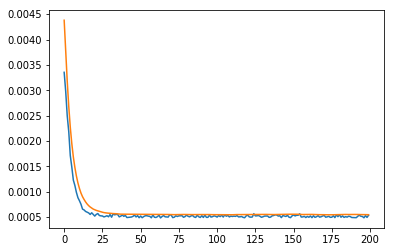

In [42]:
from matplotlib import pyplot as plt 
%matplotlib inline 

plt.plot(allloss_train)
plt.plot(allloss_test)

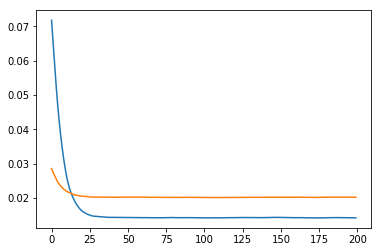

In [43]:
plt.plot(allmae_test1)
plt.plot(allmae_test2)

Run this to save the model 

In [44]:
import datetime

mystring = datetime.datetime.now().strftime("%m-%d-%H-%M")

filename_pt = mystring + "_model.pt"
filename_stats = mystring + "_stats.npz"

torch.save(net,filename_pt)

np.savez_compressed(filename_stats,test_losses = allloss_train,train_losses = allloss_train,mae_training = allmae_test2,
                   mae_eng = allmae_test1,pears_eng = allpears_test1,pears_train = allpears_test2)

/Users/nicolasfarrugia/miniconda3/envs/eeg/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type BrainNetCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/nicolasfarrugia/miniconda3/envs/eeg/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type E2EBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
